# Code for simulating global warming (loosely based on Held et al. 2009)

In [1]:
using Unitful
using PyPlot

┌ Info: Recompiling stale cache file /home/hdrake/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Info: Installing matplotlib via the Conda matplotlib package...
└ @ PyCall /home/hdrake/.julia/packages/PyCall/ttONZ/src/PyCall.jl:705
┌ Info: Running `conda install -y matplotlib` in root environment
└ @ Conda /home/hdrake/.julia/packages/Conda/kLXeC/src/Conda.jl:112


Solving environment: ...working... done

## Package Plan ##

  environment location: /home/hdrake/.julia/conda/3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.7.12               |           py37_0         3.0 MB
    cycler-0.10.0              |           py37_0          13 KB
    dbus-1.13.6                |       h746ee38_0         499 KB
    expat-2.2.6                |       he6710b0_0         146 KB
    fontconfig-2.13.0          |       h9420a91_0         227 KB
    freetype-2.9.1             |       h8a8886c_1         550 KB
    glib-2.56.2                |       hd408876_0         3.9 MB
    gst-plugins-base-1.14.0    |       hbbd80ab_1         4.8 MB
    gstreamer-1.14.0           |       hb453b48_1         3.1 MB
    icu-58.2                   |       h9c2bf20_1        10.3 MB
    jpeg-9b                    |       h024ee3a_

In [22]:
T = 0#u"K"  # surface air temperature anomaly
Td = 0#u"K" # deep ocean temperature anomaly
β = 4.6145673756#u"W/m^2/K" # derivative of outgoing flux to space with respect to T
Cf = (3600. * 24. * 365.)# surface ocean heat capacity (units?)
Cd = 1.# deep ocean heat capacity
F = 3.7#u"W/m^2"  # forcing

#τf = Cf/(β+γ)

3.7

# Example:
\begin{equation}
C_{f} \frac{\text{d}T}{\text{d}t} = -\beta T + F
\end{equation}

which we discretize as:


\begin{equation}
T_{k+1} = T_{k} + \Delta t \left(\frac{F}{C_{f}} - T_{k} \frac{\beta}{C_{f}}\right)
\end{equation}

In [23]:
Δt = 3600. * 24
tvec = Δt:Δt:365*5*Δt
Tvec=zeros(size(tvec))
Tvec[1] = T

sec_to_year = (365. * 24. * 3600.)^-1
for idx=1:length(tvec)-1
    Tvec[idx+1] = Tvec[idx] + Δt*(F/Cf - Tvec[idx]*β/Cf)
end

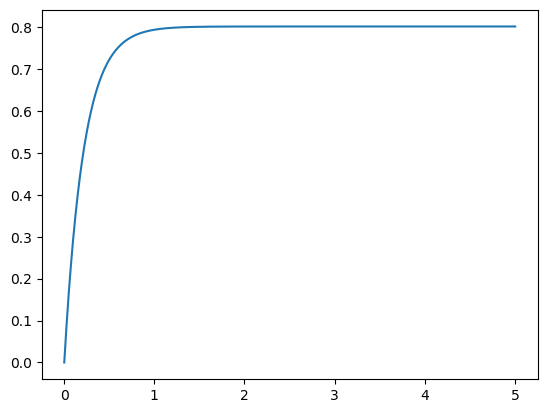

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff43b33d550>

In [24]:
plot(tvec*sec_to_year,Tvec)